In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
# loading the dataset and 21 features
df2 = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.1percent_2classes.csv")[["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", 
                "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance", "benign"]]
df8 = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.1percent_8classes.csv")[["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", 
                "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance", "label"]]
df34 = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.1percent_34classes.csv")[["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", 
                "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance", "label"]]

# Thought Process for Pipeline

# Pipeline 1
1. `Benign` vs `Attack`   
    1.1 Branch off to `Attack` 

2. `DDoS` vs `DoS` vs `Mirai` vs `Pooled1`  
    2.1 The 3 attacks were chosen due to the ratio of data available compared to the labels in `Pooled1`  
    2.2 `Pooled1` contains labels:`Spoofing`, `Recon`, `Web`, `BruteForce`  
    2.3 Branch off to `Pooled1`

3. `Spoofing` vs `Recon` vs `Pooled2`  
    3.1 The 2 attacks were chosen due to the ratio of data available compared to the labels in `Pooled2`  
    3.2 `Pooled2` contains labels: `Web`, `BruteForce`  
    3.3 Branch off to `Pooled2`
    
4. `Web` vs `BruteForce`

5. After classifying each Attack, we branch off to the attacks independently:  
    5.1 `DDoS:` 'DDoS-RSTFINFlood', 'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood', 'DDoS-ICMP_Flood', 
    'DDoS-SynonymousIP_Flood', 'DDoS-ACK_Fragmentation', 'DDoS-UDP_Fragmentation', 'DDoS-ICMP_Fragmentation', 'DDoS-SlowLoris', 'DDoS-HTTP_Flood'  
    5.2 `DoS`: 'DoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-HTTP_Flood'  
    5.3 `Mirai`: 'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain'  
    5.4 `Spoofing`: 'MITM-ArpSpoofing', 'DNS_Spoofing'  
    5.5 `Recon`: 'Recon-PingSweep', 'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan', 'Recon-HostDiscovery'  
    5.6 `Web`: 'BrowserHijacking', 'Backdoor_Malware', 'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection'  
    5.7 `BruteForce`

![Pipeline 1](https://github.com/KokYenZein/WatAI---CyberSecurity-23-24/blob/main/Pipelines/Pipeline1.png?raw=true)

# Pipeline 2
...

# Creating DataFrames

In [3]:
# Benign vs Attack dataframe
# `benign` column: True: Benign, False: Attack
df_BeAt = df2.copy()

In [4]:
# DDoS vs DoS vs Mirai vs Pooled1
remap_labels = {"Spoofing": "pooled1", "Recon": "pooled1", "Web": "pooled1", "BruteForce": "pooled1"}


df_DoDoMi = df8.copy()
df_DoDoMi["label"] = df_DoDoMi["label"].apply(lambda x: remap_labels.get(x, x))
df_DoDoMi = df_DoDoMi[df_DoDoMi['label'].isin(["DDoS", "DoS", "Mirai", "pooled1"])]

df_pooled1 = df8[df8["label"].isin(["Spoofing", "Recon", "Web", "BruteForce"])]

In [5]:
# Spoofing vs Recon vs Pooled2
remap_labels = {"Web": "pooled2", "BruteForce": "pooled2"}

df_SpRe = df_pooled1.copy()
df_SpRe["label"] = df_SpRe["label"].apply(lambda x: remap_labels.get(x, x))
df_SpRe = df_SpRe[df_SpRe['label'].isin(["Spoofing", "Recon", "pooled2"])]

df_WeBr = df_pooled1[df_pooled1["label"].isin(["Web", "BruteForce"])]

In [6]:
df_DDoS = df34[df34["label"].isin(['DDoS-RSTFINFlood', 'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood', 'DDoS-ICMP_Flood', 
                                   'DDoS-SynonymousIP_Flood', 'DDoS-ACK_Fragmentation', 'DDoS-UDP_Fragmentation', 'DDoS-ICMP_Fragmentation', 'DDoS-SlowLoris', 
                                   'DDoS-HTTP_Flood'])]
df_DoS = df34[df34["label"].isin(['DoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-HTTP_Flood'])]
df_Mirai = df34[df34["label"].isin(['Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain'])]
df_Spoofing = df34[df34["label"].isin(['MITM-ArpSpoofing', 'DNS_Spoofing'])]
df_Recon = df34[df34["label"].isin(['Recon-PingSweep', 'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan', 'Recon-HostDiscovery'])]
df_Web = df34[df34["label"].isin(['BrowserHijacking', 'Backdoor_Malware', 'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection'])]

In [7]:
df8["label"].value_counts()

label
DDoS          3398438
DoS            809091
Mirai          263398
Benign         109824
Spoofing        48659
Recon           35453
Web              2487
BruteForce       1303
Name: count, dtype: int64

In [8]:
# Validation check
[df_DoDoMi["label"].value_counts(), df_pooled1["label"].value_counts(), df_SpRe["label"].value_counts(), df_WeBr["label"].value_counts()]

[label
 DDoS       3398438
 DoS         809091
 Mirai       263398
 pooled1      87902
 Name: count, dtype: int64,
 label
 Spoofing      48659
 Recon         35453
 Web            2487
 BruteForce     1303
 Name: count, dtype: int64,
 label
 Spoofing    48659
 Recon       35453
 pooled2      3790
 Name: count, dtype: int64,
 label
 Web           2487
 BruteForce    1303
 Name: count, dtype: int64]

# Pipeline 1 Testing

# Benign vs Attack

In [9]:
# dataset used is df_BeAt
df_BeAt.head()

,duration,srate,drate,syn_flag_number,psh_flag_number,ack_flag_number,ack_count,syn_count,rst_count,header_length,...,flow_duration,avg,max,tot_sum,min,iat,magnitude,radius,variance,benign
0,64.00,48,0.0,False,False,False,1.0,0.00,0,54,...,0.000000,54.000000,54.00,567.00,54.0,83345000.0,10.392304,0.000000,0.00,False
1,65.91,29,0.0,True,False,False,0.0,0.99,0,55,...,0.000000,54.253098,58.80,571.80,54.0,82985560.0,10.416152,1.528833,0.03,False
2,64.00,24362,0.0,False,False,False,0.0,0.00,0,17230,...,0.035177,50.000000,50.00,525.00,50.0,83102410.0,10.000000,0.000000,0.00,False
3,109.80,85,0.0,False,False,True,0.0,0.00,361,389809,...,3.932406,1178.800400,2962.00,18079.40,66.0,166521020.0,48.637638,1128.301500,1.00,True
4,68.40,7890,0.0,False,False,False,0.0,0.00,0,11323,...,0.069597,53.363760,93.99,571.87,50.0,83487416.0,10.310076,15.865254,0.26,False


In [10]:
df_BeAt["benign"].value_counts()

benign
False    4558829
True      109824
Name: count, dtype: int64

In [11]:
# Preprocessing
X = df_BeAt.drop("benign", axis=1)
y = df_BeAt["benign"]

# splitting out dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# scaling features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

# hot code "label" since xgboost only accepts number types
label = LabelEncoder()
encoded_y_train = label.fit_transform(y_train)
encoded_y_test = label.fit_transform(y_test)

In [12]:
# xgboost classifier
xgc = xgb.XGBClassifier(n_estimators = 100, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:59:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              max_samples=0.9, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

      Attack      0.997     0.998     0.998    911766
      Benign      0.926     0.889     0.907     21965

    accuracy                          0.996    933731
   macro avg      0.962     0.943     0.952    933731
weighted avg      0.996     0.996     0.996    933731



<Figure size 1000x500 with 0 Axes>

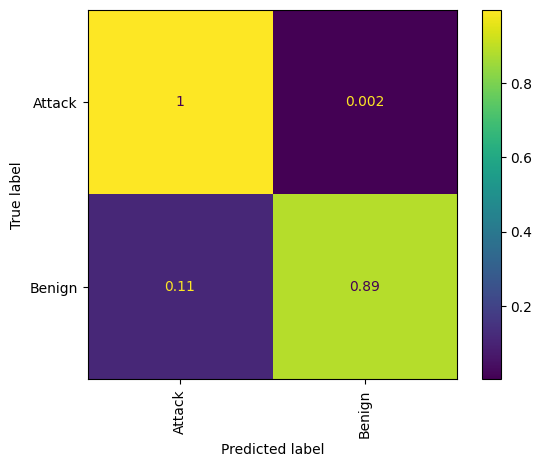

In [13]:
pred = xgc.predict(scaled_X_test)
print(classification_report(encoded_y_test, pred, target_names = ["Attack", "Benign"], digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(encoded_y_test, pred, normalize="true"), 3), 
                       display_labels = ["Attack", "Benign"]).plot()
plt.xticks(rotation=90);

In [14]:
# traditional balanced random forest classifier
tbrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                               max_features = "sqrt", class_weight = "balanced",
                               max_depth = 13, max_samples = 0.9,
                               random_state = 42)
tbrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13, max_samples=0.9,
                       n_estimators=200, oob_score=True, random_state=42)

              precision    recall  f1-score   support

      Attack      0.996     0.993     0.994    911766
      Benign      0.737     0.822     0.777     21965

    accuracy                          0.989    933731
   macro avg      0.867     0.907     0.886    933731
weighted avg      0.990     0.989     0.989    933731



<Figure size 1000x500 with 0 Axes>

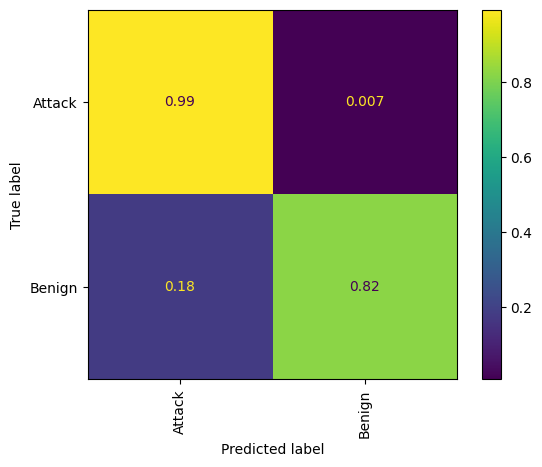

In [15]:
pred = tbrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = ["Attack", "Benign"], digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = ["Attack", "Benign"]).plot()
plt.xticks(rotation=90);

In [16]:
# inspired from Zach
# Have to play around with
import math

# Get counts in log10
y_train_count = y_train.value_counts()
y_log = y_train_count.apply(lambda x: math.log10(x))

# Find the factor needed to bring minority classes to majority
y_log_max = y_log.max()
y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

weight_dict = y_log.to_dict()
weight_dict

{False: 1.0, True: 41.51040872306767}

In [17]:
# weighted random forest classifier
wrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                              max_features = "sqrt", class_weight = weight_dict, 
                              max_depth = 13, max_samples = 0.9, 
                              random_state = 42)
wrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight={False: 1.0, True: 41.51040872306767},
                       max_depth=13, max_samples=0.9, n_estimators=200,
                       oob_score=True, random_state=42)

              precision    recall  f1-score   support

      Attack      0.998     0.992     0.995    911766
      Benign      0.741     0.921     0.821     21965

    accuracy                          0.991    933731
   macro avg      0.870     0.956     0.908    933731
weighted avg      0.992     0.991     0.991    933731



<Figure size 1000x500 with 0 Axes>

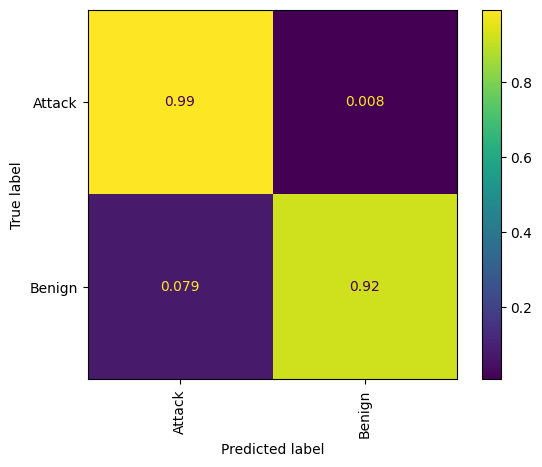

In [18]:
pred = wrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = ["Attack", "Benign"], digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = ["Attack", "Benign"]).plot()
plt.xticks(rotation=90);

In [19]:
# balanced random forest classifier
brfc = BalancedRandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                                      max_features = "sqrt", sampling_strategy="all", 
                                      max_depth = 13, max_samples = 0.9,
                                      replacement=True, random_state = 42)
brfc.fit(scaled_X_train, y_train)

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:813: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


BalancedRandomForestClassifier(max_depth=13, max_samples=0.9, n_estimators=200,
                               oob_score=True, random_state=42,
                               replacement=True, sampling_strategy='all')

              precision    recall  f1-score   support

      Attack      1.000     0.990     0.995    911766
      Benign      0.701     0.998     0.823     21965

    accuracy                          0.990    933731
   macro avg      0.850     0.994     0.909    933731
weighted avg      0.993     0.990     0.991    933731



<Figure size 1000x500 with 0 Axes>

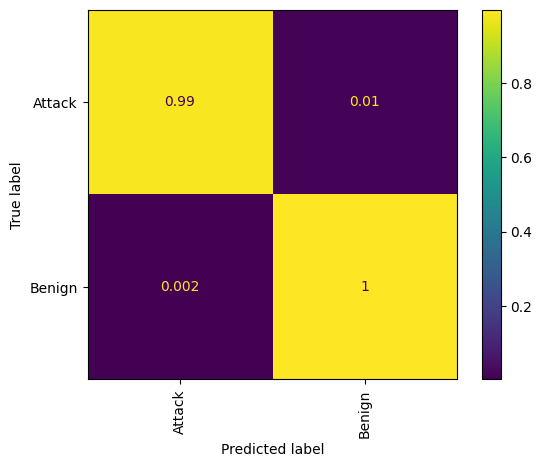

In [20]:
pred = brfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = ["Attack", "Benign"], digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = ["Attack", "Benign"]).plot();
plt.xticks(rotation=90);

# DDoS vs DoS vs Mirai vs pooled1
pooled1: Spoofing, Recon, Web, BruteForce

In [21]:
# dataset used is df_DoDoMi
df_DoDoMi.head()

,duration,srate,drate,syn_flag_number,psh_flag_number,ack_flag_number,ack_count,syn_count,rst_count,header_length,...,flow_duration,avg,max,tot_sum,min,iat,magnitude,radius,variance,label
0,64.00,48,0.0,False,False,False,1.0,0.00,0,54,...,0.000000,54.000000,54.00,567.00,54.0,83345000.0,10.392304,0.000000,0.00,DDoS
1,65.91,29,0.0,True,False,False,0.0,0.99,0,55,...,0.000000,54.253098,58.80,571.80,54.0,82985560.0,10.416152,1.528833,0.03,DoS
2,64.00,24362,0.0,False,False,False,0.0,0.00,0,17230,...,0.035177,50.000000,50.00,525.00,50.0,83102410.0,10.000000,0.000000,0.00,DDoS
4,68.40,7890,0.0,False,False,False,0.0,0.00,0,11323,...,0.069597,53.363760,93.99,571.87,50.0,83487416.0,10.310076,15.865254,0.26,DDoS
5,64.00,15,0.0,True,False,False,0.0,1.00,0,54,...,0.000000,54.000000,54.00,567.00,54.0,83093270.0,10.392304,0.000000,0.00,DDoS


In [22]:
df_DoDoMi["label"].value_counts()

label
DDoS       3398438
DoS         809091
Mirai       263398
pooled1      87902
Name: count, dtype: int64

In [23]:
# Preprocessing
X = df_DoDoMi.drop("label", axis=1)
y = df_DoDoMi["label"]

# splitting out dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# scaling features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

# hot code "label" since xgboost only accepts number types
label = LabelEncoder()
encoded_y_train = label.fit_transform(y_train)
encoded_y_test = label.fit_transform(y_test)

In [24]:
target_names = ["DDoS", "DoS", "Mirai", "pooled1"]

In [25]:
# xgboost classifier
xgc = xgb.XGBClassifier(n_estimators = 200, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:02:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              max_samples=0.9, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

        DDoS      0.999     0.966     0.982    679688
         DoS      0.875     0.998     0.932    161818
       Mirai      0.999     1.000     1.000     52680
     pooled1      0.991     0.988     0.990     17580

    accuracy                          0.974    911766
   macro avg      0.966     0.988     0.976    911766
weighted avg      0.977     0.974     0.974    911766



<Figure size 1000x500 with 0 Axes>

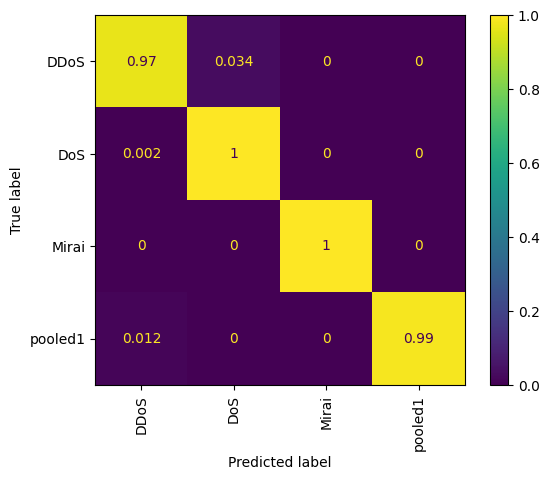

In [26]:
pred = xgc.predict(scaled_X_test)
print(classification_report(encoded_y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(encoded_y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [27]:
# traditional balanced random forest classifier
tbrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                               max_features = "sqrt", class_weight = "balanced",
                               max_depth = 13, max_samples = 0.9,
                               random_state = 42)
tbrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13, max_samples=0.9,
                       n_estimators=200, oob_score=True, random_state=42)

              precision    recall  f1-score   support

        DDoS      0.997     0.965     0.981    679688
         DoS      0.873     0.988     0.927    161818
       Mirai      1.000     1.000     1.000     52680
     pooled1      0.959     1.000     0.979     17580

    accuracy                          0.972    911766
   macro avg      0.957     0.988     0.972    911766
weighted avg      0.975     0.972     0.972    911766



<Figure size 1000x500 with 0 Axes>

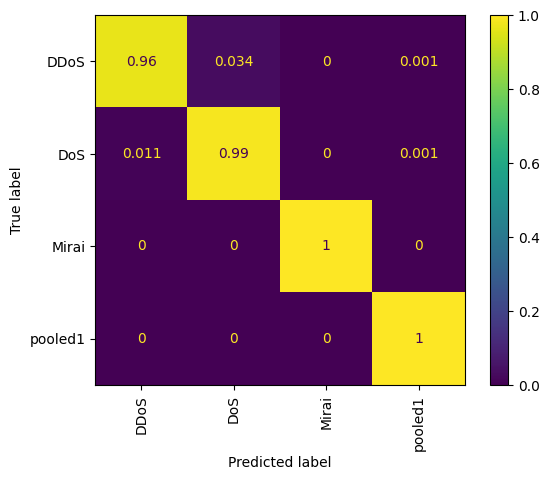

In [28]:
pred = tbrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [29]:
# inspired from Zach
# Have to play around with
import math

# Get counts in log10
y_train_count = y_train.value_counts()
y_log = y_train_count.apply(lambda x: math.log10(x))

# Find the factor needed to bring minority classes to majority
y_log_max = y_log.max()
y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

weight_dict = y_log.to_dict()
weight_dict

{'DDoS': 1.0,
 'DoS': 4.200314241440627,
 'Mirai': 12.902314942245097,
 'pooled1': 38.66144307613552}

In [30]:
# weighted random forest classifier
wrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                              max_features = "sqrt", class_weight = weight_dict, 
                              max_depth = 13, max_samples = 0.9, 
                              random_state = 42)
wrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight={'DDoS': 1.0, 'DoS': 4.200314241440627,
                                     'Mirai': 12.902314942245097,
                                     'pooled1': 38.66144307613552},
                       max_depth=13, max_samples=0.9, n_estimators=200,
                       oob_score=True, random_state=42)

              precision    recall  f1-score   support

        DDoS      0.997     0.965     0.981    679688
         DoS      0.873     0.987     0.927    161818
       Mirai      1.000     1.000     1.000     52680
     pooled1      0.960     1.000     0.980     17580

    accuracy                          0.972    911766
   macro avg      0.958     0.988     0.972    911766
weighted avg      0.974     0.972     0.972    911766



<Figure size 1000x500 with 0 Axes>

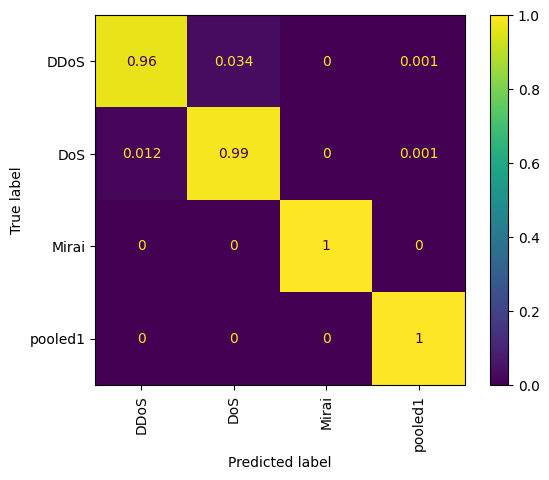

In [31]:
pred = wrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [32]:
# balanced random forest classifier
brfc = BalancedRandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                                      max_features = "sqrt", sampling_strategy="all", 
                                      max_depth = 13, max_samples = 0.9,
                                      replacement=True, random_state = 42)
brfc.fit(scaled_X_train, y_train)

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:813: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


BalancedRandomForestClassifier(max_depth=13, max_samples=0.9, n_estimators=200,
                               oob_score=True, random_state=42,
                               replacement=True, sampling_strategy='all')

              precision    recall  f1-score   support

        DDoS      1.000     0.964     0.981    679688
         DoS      0.874     0.997     0.932    161818
       Mirai      0.999     0.999     0.999     52680
     pooled1      0.914     1.000     0.955     17580

    accuracy                          0.972    911766
   macro avg      0.947     0.990     0.967    911766
weighted avg      0.976     0.972     0.973    911766



<Figure size 1000x500 with 0 Axes>

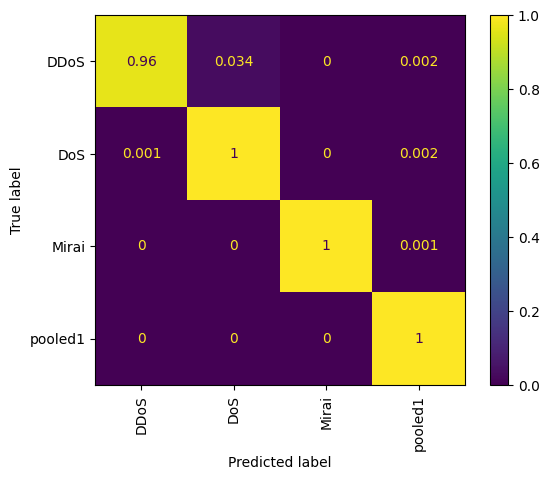

In [33]:
pred = brfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot();
plt.xticks(rotation=90);

# Spoofing vs Recon vs pooled2
pooled2: Web, BruteForce

In [34]:
# dataset used is df_SpRe
df_SpRe.head()

,duration,srate,drate,syn_flag_number,psh_flag_number,ack_flag_number,ack_count,syn_count,rst_count,header_length,...,flow_duration,avg,max,tot_sum,min,iat,magnitude,radius,variance,label
28,61.2,15,0.0,False,False,True,0.2,3.0,18,19451,...,1.585993,141.53027,648.0,2168.5,57.0,1.664289e+08,16.837660,240.52281,1.0,Recon
54,59.2,91,0.0,False,False,True,0.0,1.8,220,148832,...,6.285090,1172.37930,2962.0,18109.4,66.0,1.666123e+08,48.183727,1968.81290,1.0,Spoofing
68,60.5,311,0.0,False,False,True,0.0,0.0,2529,2840113,...,8.126129,385.70920,1224.4,3114.2,66.0,2.575159e-04,24.115310,613.82214,0.5,Spoofing
203,192.0,60,0.0,False,False,True,0.0,0.0,941,827634,...,15.624565,488.95720,1514.0,1805.6,205.4,4.868031e-04,29.563864,712.04270,0.9,Recon
244,247.0,4275,0.0,False,False,True,0.0,0.0,829,803480,...,0.194001,2192.23300,4350.0,33724.2,1494.0,1.666038e+08,66.134380,1444.88060,1.0,Spoofing


In [35]:
df_SpRe["label"].value_counts()

label
Spoofing    48659
Recon       35453
pooled2      3790
Name: count, dtype: int64

In [36]:
# Preprocessing
X = df_SpRe.drop("label", axis=1)
y = df_SpRe["label"]

# splitting out dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# scaling features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

# hot code "label" since xgboost only accepts number types
label = LabelEncoder()
encoded_y_train = label.fit_transform(y_train)
encoded_y_test = label.fit_transform(y_test)

In [37]:
target_names = ["Recon", "Spoofing", "pooled2"]

In [38]:
# xgboost classifier
xgc = xgb.XGBClassifier(n_estimators = 200, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:31:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              max_samples=0.9, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

       Recon      0.528     0.891     0.663      7091
    Spoofing      0.825     0.459     0.590      9732
     pooled2      0.779     0.219     0.342       758

    accuracy                          0.623     17581
   macro avg      0.711     0.523     0.532     17581
weighted avg      0.704     0.623     0.609     17581



<Figure size 1000x500 with 0 Axes>

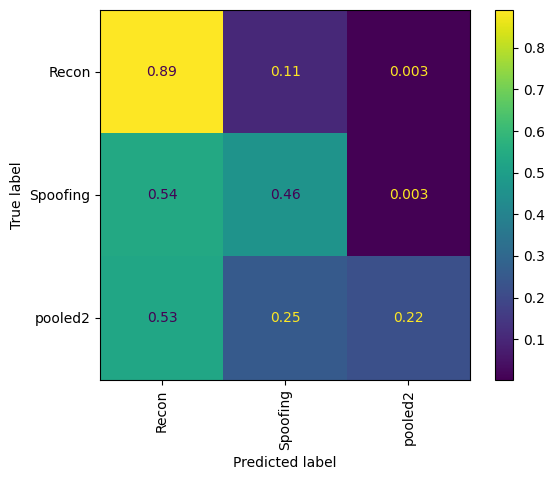

In [39]:
pred = xgc.predict(scaled_X_test)
print(classification_report(encoded_y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(encoded_y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [40]:
# traditional balanced random forest classifier
tbrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                               max_features = "sqrt", class_weight = "balanced",
                               max_depth = 13, max_samples = 0.9,
                               random_state = 42)
tbrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13, max_samples=0.9,
                       n_estimators=200, oob_score=True, random_state=42)

              precision    recall  f1-score   support

       Recon      0.631     0.870     0.731      7091
    Spoofing      0.924     0.585     0.717      9732
     pooled2      0.158     0.340     0.216       758

    accuracy                          0.690     17581
   macro avg      0.571     0.599     0.555     17581
weighted avg      0.773     0.690     0.701     17581



<Figure size 1000x500 with 0 Axes>

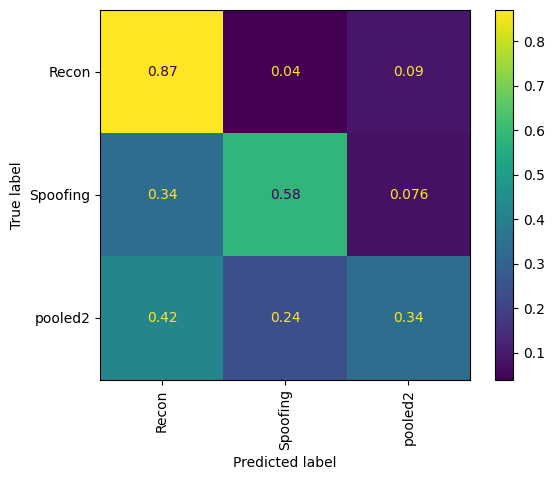

In [41]:
pred = tbrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [42]:
# inspired from Zach
# Have to play around with
import math

# Get counts in log10
y_train_count = y_train.value_counts()
y_log = y_train_count.apply(lambda x: math.log10(x))

# Find the factor needed to bring minority classes to majority
y_log_max = y_log.max()
y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

weight_dict = y_log.to_dict()
weight_dict

{'Spoofing': 1.0, 'Recon': 1.3725054650588826, 'pooled2': 12.838720316622704}

In [43]:
# weighted random forest classifier
wrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                              max_features = "sqrt", class_weight = weight_dict, 
                              max_depth = 13, max_samples = 0.9, 
                              random_state = 42)
wrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight={'Recon': 1.3725054650588826,
                                     'Spoofing': 1.0,
                                     'pooled2': 12.838720316622704},
                       max_depth=13, max_samples=0.9, n_estimators=200,
                       oob_score=True, random_state=42)

              precision    recall  f1-score   support

       Recon      0.639     0.867     0.736      7091
    Spoofing      0.926     0.596     0.725      9732
     pooled2      0.158     0.354     0.219       758

    accuracy                          0.695     17581
   macro avg      0.574     0.606     0.560     17581
weighted avg      0.777     0.695     0.708     17581



<Figure size 1000x500 with 0 Axes>

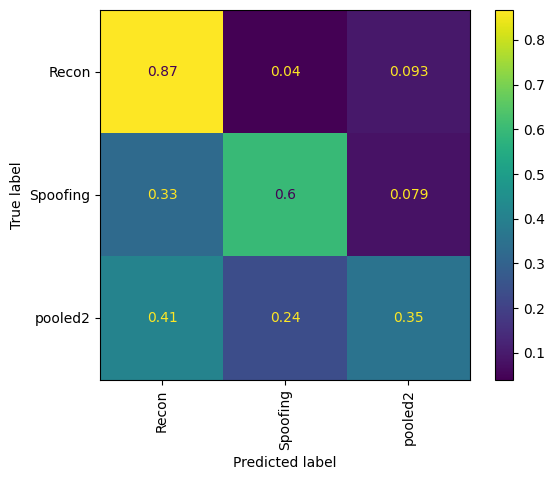

In [44]:
pred = wrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [45]:
# balanced random forest classifier
brfc = BalancedRandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                                      max_features = "sqrt", sampling_strategy="all", 
                                      max_depth = 13, max_samples = 0.9,
                                      replacement=True, random_state = 42)
brfc.fit(scaled_X_train, y_train)

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:813: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


BalancedRandomForestClassifier(max_depth=13, max_samples=0.9, n_estimators=200,
                               oob_score=True, random_state=42,
                               replacement=True, sampling_strategy='all')

              precision    recall  f1-score   support

       Recon      0.703     0.817     0.756      7091
    Spoofing      0.941     0.654     0.772      9732
     pooled2      0.132     0.447     0.204       758

    accuracy                          0.711     17581
   macro avg      0.592     0.640     0.577     17581
weighted avg      0.810     0.711     0.741     17581



<Figure size 1000x500 with 0 Axes>

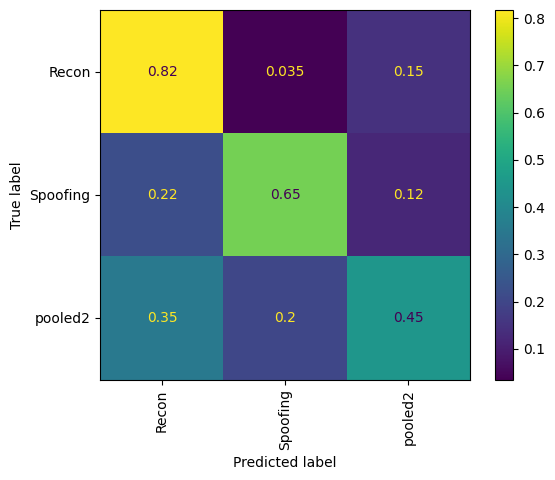

In [46]:
pred = brfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot();
plt.xticks(rotation=90);

# Web vs BruteForce

In [47]:
# dataset used is df_WeBr
df_WeBr.head()

,duration,srate,drate,syn_flag_number,psh_flag_number,ack_flag_number,ack_count,syn_count,rst_count,header_length,...,flow_duration,avg,max,tot_sum,min,iat,magnitude,radius,variance,label
2090,201.2,9,0.0,False,False,True,0.4,3.6,65,40801,...,18.170023,102.08329,306.6,648.2,54.0,1.410642e-02,13.976114,124.982990,0.6,BruteForce
4651,102.2,2,0.0,False,False,False,0.0,0.0,10,11273,...,75.592316,75.72852,208.6,1180.8,50.0,1.666014e+08,12.310367,61.137756,1.0,BruteForce
4996,57.6,422,0.0,False,False,True,0.0,1.2,1,185,...,0.007006,73.31754,82.4,404.0,65.2,2.261019e-03,12.108622,8.790977,0.8,BruteForce
5456,183.7,8,0.0,False,False,True,0.0,1.4,4,3338,...,6.665868,332.18076,1240.0,5532.2,46.0,1.676297e+08,25.019814,631.782400,1.0,Web
9576,64.0,180,0.0,False,False,True,0.0,2.0,173,175475,...,0.967932,78.00000,78.0,429.0,78.0,4.100800e-06,12.489996,0.000000,0.0,Web


In [48]:
df_WeBr["label"].value_counts()

label
Web           2487
BruteForce    1303
Name: count, dtype: int64

In [49]:
# Preprocessing
X = df_WeBr.drop("label", axis=1)
y = df_WeBr["label"]

# splitting out dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# scaling features
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

# hot code "label" since xgboost only accepts number types
label = LabelEncoder()
encoded_y_train = label.fit_transform(y_train)
encoded_y_test = label.fit_transform(y_test)

In [50]:
target_names = ["Web", "BruteForce"]

In [51]:
# xgboost classifier
xgc = xgb.XGBClassifier(n_estimators = 200, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9)
xgc.fit(scaled_X_train, encoded_y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:33:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_samples" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              max_samples=0.9, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

         Web      0.857     0.092     0.166       261
  BruteForce      0.675     0.992     0.804       497

    accuracy                          0.682       758
   macro avg      0.766     0.542     0.485       758
weighted avg      0.738     0.682     0.584       758



<Figure size 1000x500 with 0 Axes>

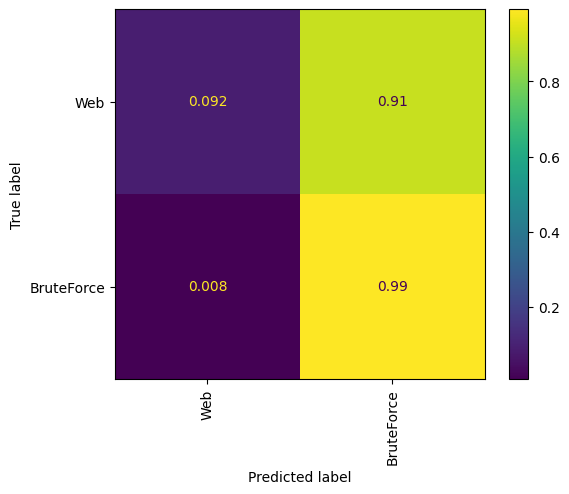

In [52]:
pred = xgc.predict(scaled_X_test)
print(classification_report(encoded_y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(encoded_y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [53]:
# traditional balanced random forest classifier
tbrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                               max_features = "sqrt", class_weight = "balanced",
                               max_depth = 13, max_samples = 0.9,
                               random_state = 42)
tbrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13, max_samples=0.9,
                       n_estimators=200, oob_score=True, random_state=42)

              precision    recall  f1-score   support

         Web      1.000     0.199     0.332       261
  BruteForce      0.704     1.000     0.826       497

    accuracy                          0.724       758
   macro avg      0.852     0.600     0.579       758
weighted avg      0.806     0.724     0.656       758



<Figure size 1000x500 with 0 Axes>

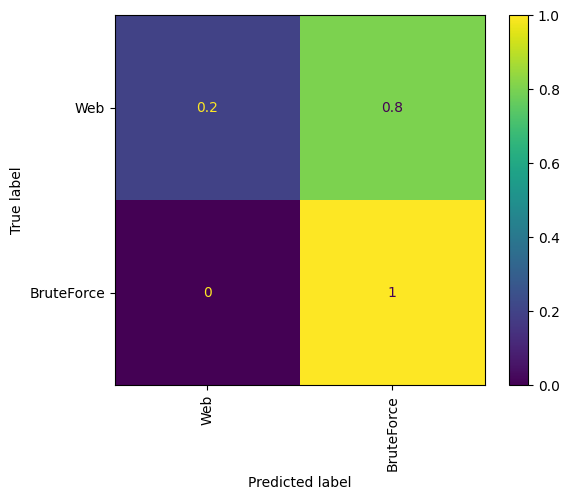

In [54]:
pred = tbrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [55]:
# inspired from Zach
# Have to play around with
import math

# Get counts in log10
y_train_count = y_train.value_counts()
y_log = y_train_count.apply(lambda x: math.log10(x))

# Find the factor needed to bring minority classes to majority
y_log_max = y_log.max()
y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

weight_dict = y_log.to_dict()
weight_dict

{'Web': 1.0, 'BruteForce': 1.9097888675623798}

In [56]:
# weighted random forest classifier
wrfc = RandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                              max_features = "sqrt", class_weight = weight_dict, 
                              max_depth = 13, max_samples = 0.9, 
                              random_state = 42)
wrfc.fit(scaled_X_train, y_train)

RandomForestClassifier(class_weight={'BruteForce': 1.9097888675623798,
                                     'Web': 1.0},
                       max_depth=13, max_samples=0.9, n_estimators=200,
                       oob_score=True, random_state=42)

              precision    recall  f1-score   support

         Web      1.000     0.188     0.316       261
  BruteForce      0.701     1.000     0.824       497

    accuracy                          0.720       758
   macro avg      0.850     0.594     0.570       758
weighted avg      0.804     0.720     0.649       758



<Figure size 1000x500 with 0 Axes>

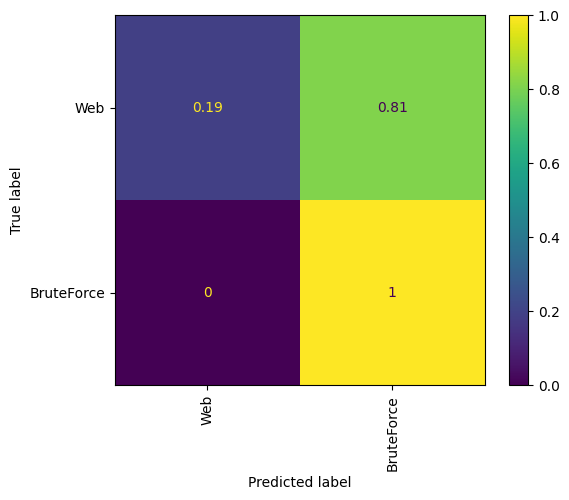

In [57]:
pred = wrfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot()
plt.xticks(rotation=90);

In [58]:
# balanced random forest classifier
brfc = BalancedRandomForestClassifier(n_estimators = 200, bootstrap = True, oob_score = True, 
                                      max_features = "sqrt", sampling_strategy="all", 
                                      max_depth = 13, max_samples = 0.9,
                                      replacement=True, random_state = 42)
brfc.fit(scaled_X_train, y_train)

BalancedRandomForestClassifier(max_depth=13, max_samples=0.9, n_estimators=200,
                               oob_score=True, random_state=42,
                               replacement=True, sampling_strategy='all')

              precision    recall  f1-score   support

         Web      0.890     0.280     0.426       261
  BruteForce      0.722     0.982     0.832       497

    accuracy                          0.740       758
   macro avg      0.806     0.631     0.629       758
weighted avg      0.780     0.740     0.692       758



<Figure size 1000x500 with 0 Axes>

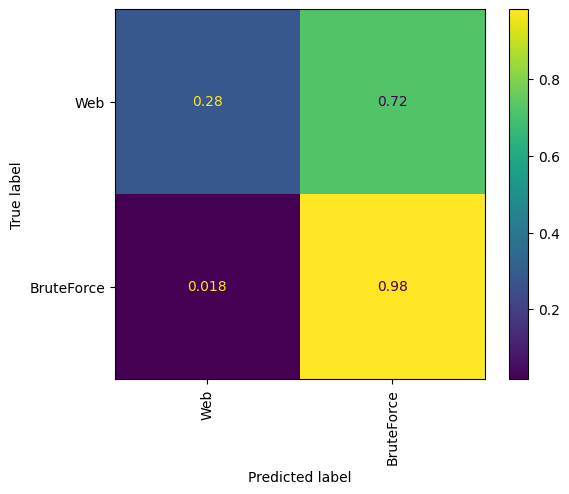

In [59]:
pred = brfc.predict(scaled_X_test)
print(classification_report(y_test, pred, target_names = target_names, digits = 3))

plt.figure(figsize = (4, 2), dpi=250)
ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 3), 
                       display_labels = target_names).plot();
plt.xticks(rotation=90);